### Setting up FourRooms

In [54]:
from deep_rl.component.fourrooms import *

/home/surya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/home/surya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


Text(0.5,1,'plot in log scale')

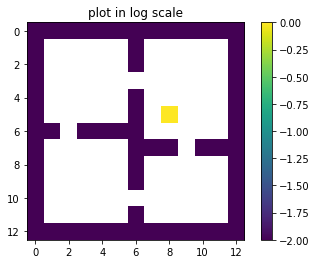

In [14]:
plt.imshow(np.log10(env.render_state())), plt.colorbar()
plt.title('plot in log scale')

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.    0.    0.    0.    0.    0.01  0.    0.    0.    0.
  0.    0.01  0.01  0.    0.    0.    0.    0.    0.01  0.    0.    0.
  0.    0.    0.01  0.01  0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.01  0.01  0.    0.    0.    0.    0.    0.01  0.
  0.    0.    0.    0.    0.01  0.01  0.    0.    0.    0.    0.    0.01
  0.    1.    0.    0.    0.    0.01  0.01  0.01  0.    0.01  0.01  0.01
  0.01  0.    0.    0.    0.    0.    0.01  0.01  0.    0.    0.    0.
  0.    0.01  0.01  0.01 -0.01  0.01  0.01  0.01  0.01  0.    0.    0.
  0.    0.    0.01  0.    0.    0.    0.    0.    0.01  0.01  0.    0.
  0.    0.    0.    0.01  0.    0.    0.    0.    0.    0.01  0.01  0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.01  0.01
  0.    0.    0.    0.    0.    0.01  0.    0.    0.    0.    0.    0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01 

(<matplotlib.axes._subplots.AxesSubplot at 0x7fab0e9d46d8>,
 <matplotlib.image.AxesImage at 0x7fab0e8af0b8>)

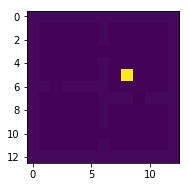

In [55]:
env = FourRoomsMatrix()
state = env.reset()
print(state)
plt.subplot(121), plt.imshow(state.reshape((13,13)))
# action = env.action_space.sample()
# state, reward, done, info = env.step(action)
# print(reward, done, info)
# plt.subplot(122), plt.imshow(state.reshape((13,13))); plt.show()
# print(action)

In [9]:
env.observation_space

Box(169,)

### Run DQN on 4 rooms

In [1]:
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange, tqdm
import random
import numpy as np
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [16]:
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(676,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    return agent

In [3]:
game = 'FourRoomsMatrix'
agent = dqn_feature(game=game)

2020-05-23 17:35:07,762 - root - INFO: steps 0, episodic_return_test -200.00(0.00)


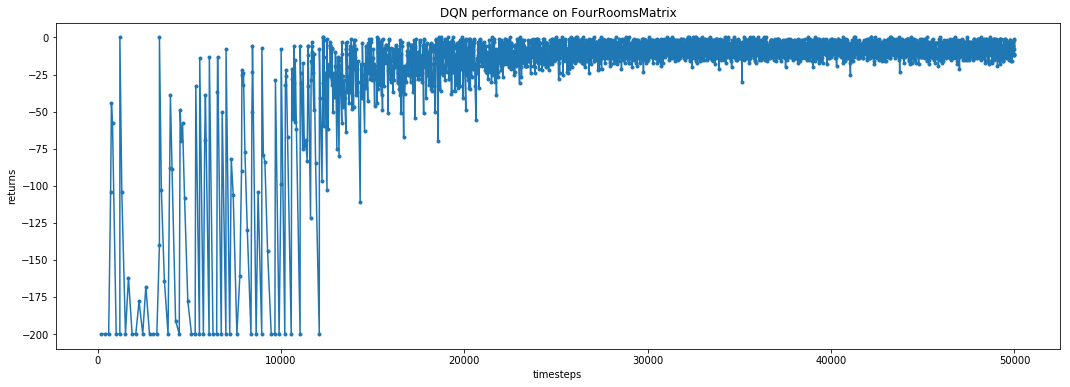

(Text(0.5,1,'DQN performance on FourRoomsMatrix'), None)

In [9]:
plt.figure(figsize=(18,6))
plt.plot(np.array(agent.returns)[:,0], np.array(agent.returns)[:,1], '.-')
plt.xlabel('timesteps'), plt.ylabel('returns')
plt.title('DQN performance on ' + game), plt.show()

In [5]:
def avdsr_feature(**kwargs):
    kwargs['tag'] = 'Training avDSR based on DQN agents'
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.002)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), hidden_units=(), config=0) #CHECK
    config.replay_fn = lambda: Replay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1, 1, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 2e5
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()

In [6]:
avdsr = avdsr_feature(game='FourRoomsMatrixNoTerm', agents=[agent], choice=0)

2020-05-23 17:35:19,782 - root - INFO: steps 0, 233016888.89 steps/s
2020-05-23 17:35:21,848 - root - INFO: steps 1000, 484.22 steps/s
2020-05-23 17:35:23,347 - root - INFO: steps 2000, 668.01 steps/s
2020-05-23 17:35:24,986 - root - INFO: steps 3000, 610.36 steps/s
2020-05-23 17:35:27,119 - root - INFO: steps 4000, 469.19 steps/s
2020-05-23 17:35:28,749 - root - INFO: steps 5000, 614.02 steps/s
2020-05-23 17:35:30,586 - root - INFO: steps 6000, 545.08 steps/s
2020-05-23 17:35:32,307 - root - INFO: steps 7000, 581.35 steps/s
2020-05-23 17:35:33,899 - root - INFO: steps 8000, 628.84 steps/s
2020-05-23 17:35:35,858 - root - INFO: steps 9000, 511.07 steps/s
2020-05-23 17:35:37,862 - root - INFO: steps 10000, 499.81 steps/s
2020-05-23 17:35:39,538 - root - INFO: steps 11000, 596.99 steps/s
2020-05-23 17:35:41,327 - root - INFO: steps 12000, 559.42 steps/s
2020-05-23 17:35:43,221 - root - INFO: steps 13000, 528.47 steps/s
2020-05-23 17:35:45,520 - root - INFO: steps 14000, 435.42 steps/s
20

2020-05-23 17:39:57,784 - root - INFO: steps 123000, 424.24 steps/s
2020-05-23 17:39:59,971 - root - INFO: steps 124000, 457.72 steps/s
2020-05-23 17:40:02,266 - root - INFO: steps 125000, 436.02 steps/s
2020-05-23 17:40:04,882 - root - INFO: steps 126000, 382.71 steps/s
2020-05-23 17:40:07,472 - root - INFO: steps 127000, 386.44 steps/s
2020-05-23 17:40:09,985 - root - INFO: steps 128000, 398.38 steps/s
2020-05-23 17:40:12,681 - root - INFO: steps 129000, 371.47 steps/s
2020-05-23 17:40:14,742 - root - INFO: steps 130000, 485.37 steps/s
2020-05-23 17:40:17,388 - root - INFO: steps 131000, 378.17 steps/s
2020-05-23 17:40:19,736 - root - INFO: steps 132000, 426.10 steps/s
2020-05-23 17:40:22,493 - root - INFO: steps 133000, 362.89 steps/s
2020-05-23 17:40:24,479 - root - INFO: steps 134000, 504.11 steps/s
2020-05-23 17:40:27,330 - root - INFO: steps 135000, 350.88 steps/s
2020-05-23 17:40:30,083 - root - INFO: steps 136000, 363.52 steps/s
2020-05-23 17:40:32,458 - root - INFO: steps 137

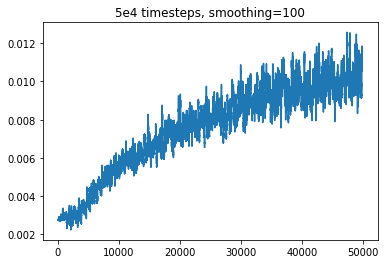

(Text(0.5,1,'5e4 timesteps, smoothing=100'), None)

In [7]:
loss_lr_em3 = avdsr.loss_vec
kernel = 100
plt.plot(convolve(avdsr.loss_vec, kernel))
plt.title('5e4 timesteps, smoothing=' + str(kernel)), plt.show()
# plt.subplot(122), plt.plot(avdsr.retu)

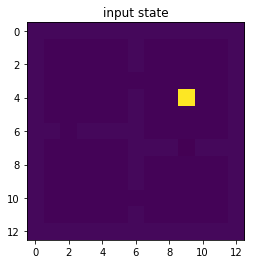

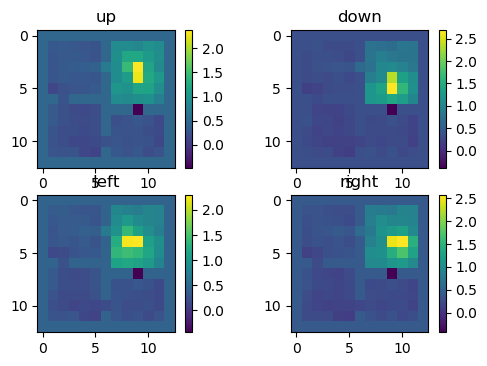

In [8]:
from deep_rl.component.fourrooms import FourRoomsMatrix
env = FourRoomsMatrix()
state = env.reset()
env.step(env.action_space.sample())
env.step(env.action_space.sample())
env.step(env.action_space.sample())
state, _, _, _ = env.step(env.action_space.sample())
plt.imshow(env.render()); plt.title('input state'), plt.show()
_, out, _ = avdsr.network(tensor(state).unsqueeze(0))

dirs = {0: 'up', 1: 'down', 2:'left', 3:'right'}

plt.figure(dpi=100)
psi = out.detach().numpy()
for i in range(4):
    psi_a = psi[0,i,:]
    plt.subplot(2,2,i+1)
    plt.imshow(psi_a.reshape((13,13)))
    plt.title(dirs[i])
    plt.colorbar()

plt.show()

In [17]:
params_count(avdsr.network.psi2q)

169

### Comparing performance:

Likely to improve if DSR is trained for longer with a smaller learning rate

- DQN: 169 -> 676 -> 4
- avDSR: 169 -> 676 -> 4

In [17]:
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), config=0)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        print(agent.network.load_state_dict(ref.network.state_dict(), strict=False))
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
    return agent

In [10]:
def runNAgents(function, runs, store=True, freeze=0, ref=None):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in trange(runs, desc='runs'): 
        agent = function(game='FourRoomsMatrix', freeze=freeze, ref=ref)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn

In [27]:
r_c0 = runNAgents(dsr_feature_init, runs=3, freeze=2, ref=avdsr)
# r_c1 = runNAgents(dsr_feature_init, runs=3, freeze=2, ref=avdsr)
r_dqn_base2 = runNAgents(dqn_feature, runs=3)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])


2020-05-23 17:56:34,151 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-05-23 17:56:42,171 - root - INFO: steps 5000, episodic_return_test -83.40(30.12)
2020-05-23 17:56:49,611 - root - INFO: steps 10000, episodic_return_test -65.30(27.89)
2020-05-23 17:57:01,454 - root - INFO: steps 15000, episodic_return_test -6.10(1.35)
2020-05-23 17:57:12,227 - root - INFO: steps 20000, episodic_return_test -7.70(1.11)
2020-05-23 17:57:22,608 - root - INFO: steps 25000, episodic_return_test -121.10(30.56)
2020-05-23 17:57:31,365 - root - INFO: steps 30000, episodic_return_test -5.70(1.18)
2020-05-23 17:57:39,278 - root - INFO: steps 35000, episodic_return_test -4.60(0.84)
2020-05-23 17:57:48,324 - root - INFO: steps 40000, episodic_return_test -5.30(1.14)
2020-05-23 17:57:56,447 - root - INFO: steps 45000, episodic_return_test -7.80(1.45)
2020-05-23 17:58:05,890 - root - INFO: steps 50000, episodic_return_test -6.70(1.39)


IncompatibleKeys(missing_keys=[], unexpected_keys=[])


2020-05-23 17:58:07,084 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-05-23 17:58:16,768 - root - INFO: steps 5000, episodic_return_test -101.40(31.19)
2020-05-23 17:58:27,941 - root - INFO: steps 10000, episodic_return_test -64.00(28.16)
2020-05-23 17:58:37,862 - root - INFO: steps 15000, episodic_return_test -7.10(0.96)
2020-05-23 17:58:47,849 - root - INFO: steps 20000, episodic_return_test -6.90(1.38)
2020-05-23 17:58:58,936 - root - INFO: steps 25000, episodic_return_test -102.40(30.88)
2020-05-23 17:59:08,500 - root - INFO: steps 30000, episodic_return_test -7.40(1.34)
2020-05-23 17:59:17,579 - root - INFO: steps 35000, episodic_return_test -4.90(0.97)
2020-05-23 17:59:25,630 - root - INFO: steps 40000, episodic_return_test -6.80(1.21)
2020-05-23 17:59:33,520 - root - INFO: steps 45000, episodic_return_test -6.20(1.21)
2020-05-23 17:59:41,141 - root - INFO: steps 50000, episodic_return_test -5.40(1.09)


IncompatibleKeys(missing_keys=[], unexpected_keys=[])


2020-05-23 17:59:42,001 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-05-23 17:59:50,150 - root - INFO: steps 5000, episodic_return_test -83.40(30.12)
2020-05-23 17:59:57,559 - root - INFO: steps 10000, episodic_return_test -6.40(1.20)
2020-05-23 18:00:05,275 - root - INFO: steps 15000, episodic_return_test -7.00(1.23)
2020-05-23 18:00:13,047 - root - INFO: steps 20000, episodic_return_test -4.30(1.04)
2020-05-23 18:00:21,102 - root - INFO: steps 25000, episodic_return_test -64.60(28.04)
2020-05-23 18:00:28,908 - root - INFO: steps 30000, episodic_return_test -6.30(0.99)
2020-05-23 18:00:36,596 - root - INFO: steps 35000, episodic_return_test -5.20(1.33)
2020-05-23 18:00:44,643 - root - INFO: steps 40000, episodic_return_test -7.10(1.21)
2020-05-23 18:00:52,905 - root - INFO: steps 45000, episodic_return_test -6.90(1.04)
2020-05-23 18:01:01,440 - root - INFO: steps 50000, episodic_return_test -6.90(1.25)


2020-05-23 18:01:02,275 - root - INFO: steps 0, episodic_return_test -180.20(18.78)
2020-05-23 18:01:11,474 - root - INFO: steps 5000, episodic_return_test -180.50(18.50)
2020-05-23 18:01:19,374 - root - INFO: steps 10000, episodic_return_test -82.00(30.47)
2020-05-23 18:01:26,892 - root - INFO: steps 15000, episodic_return_test -6.30(1.06)
2020-05-23 18:01:34,721 - root - INFO: steps 20000, episodic_return_test -6.10(0.97)
2020-05-23 18:01:42,577 - root - INFO: steps 25000, episodic_return_test -8.30(0.88)
2020-05-23 18:01:50,315 - root - INFO: steps 30000, episodic_return_test -4.80(1.02)
2020-05-23 18:01:58,744 - root - INFO: steps 35000, episodic_return_test -4.70(1.23)
2020-05-23 18:02:07,818 - root - INFO: steps 40000, episodic_return_test -6.40(1.09)
2020-05-23 18:02:17,215 - root - INFO: steps 45000, episodic_return_test -4.70(0.75)
2020-05-23 18:02:26,641 - root - INFO: steps 50000, episodic_return_test -7.10(1.29)
2020-05-23 18:02:27,422 - root - INFO: steps 0, episodic_retur

In [18]:
convolve(np.zeros(100),10).shape

(91,)

In [25]:
def plot_rewards(rewards, plot_seperate=True , clip=50000, title='unnamed'):
    smooth = 500
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(18,6), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(loc='lower right'), plt.show()

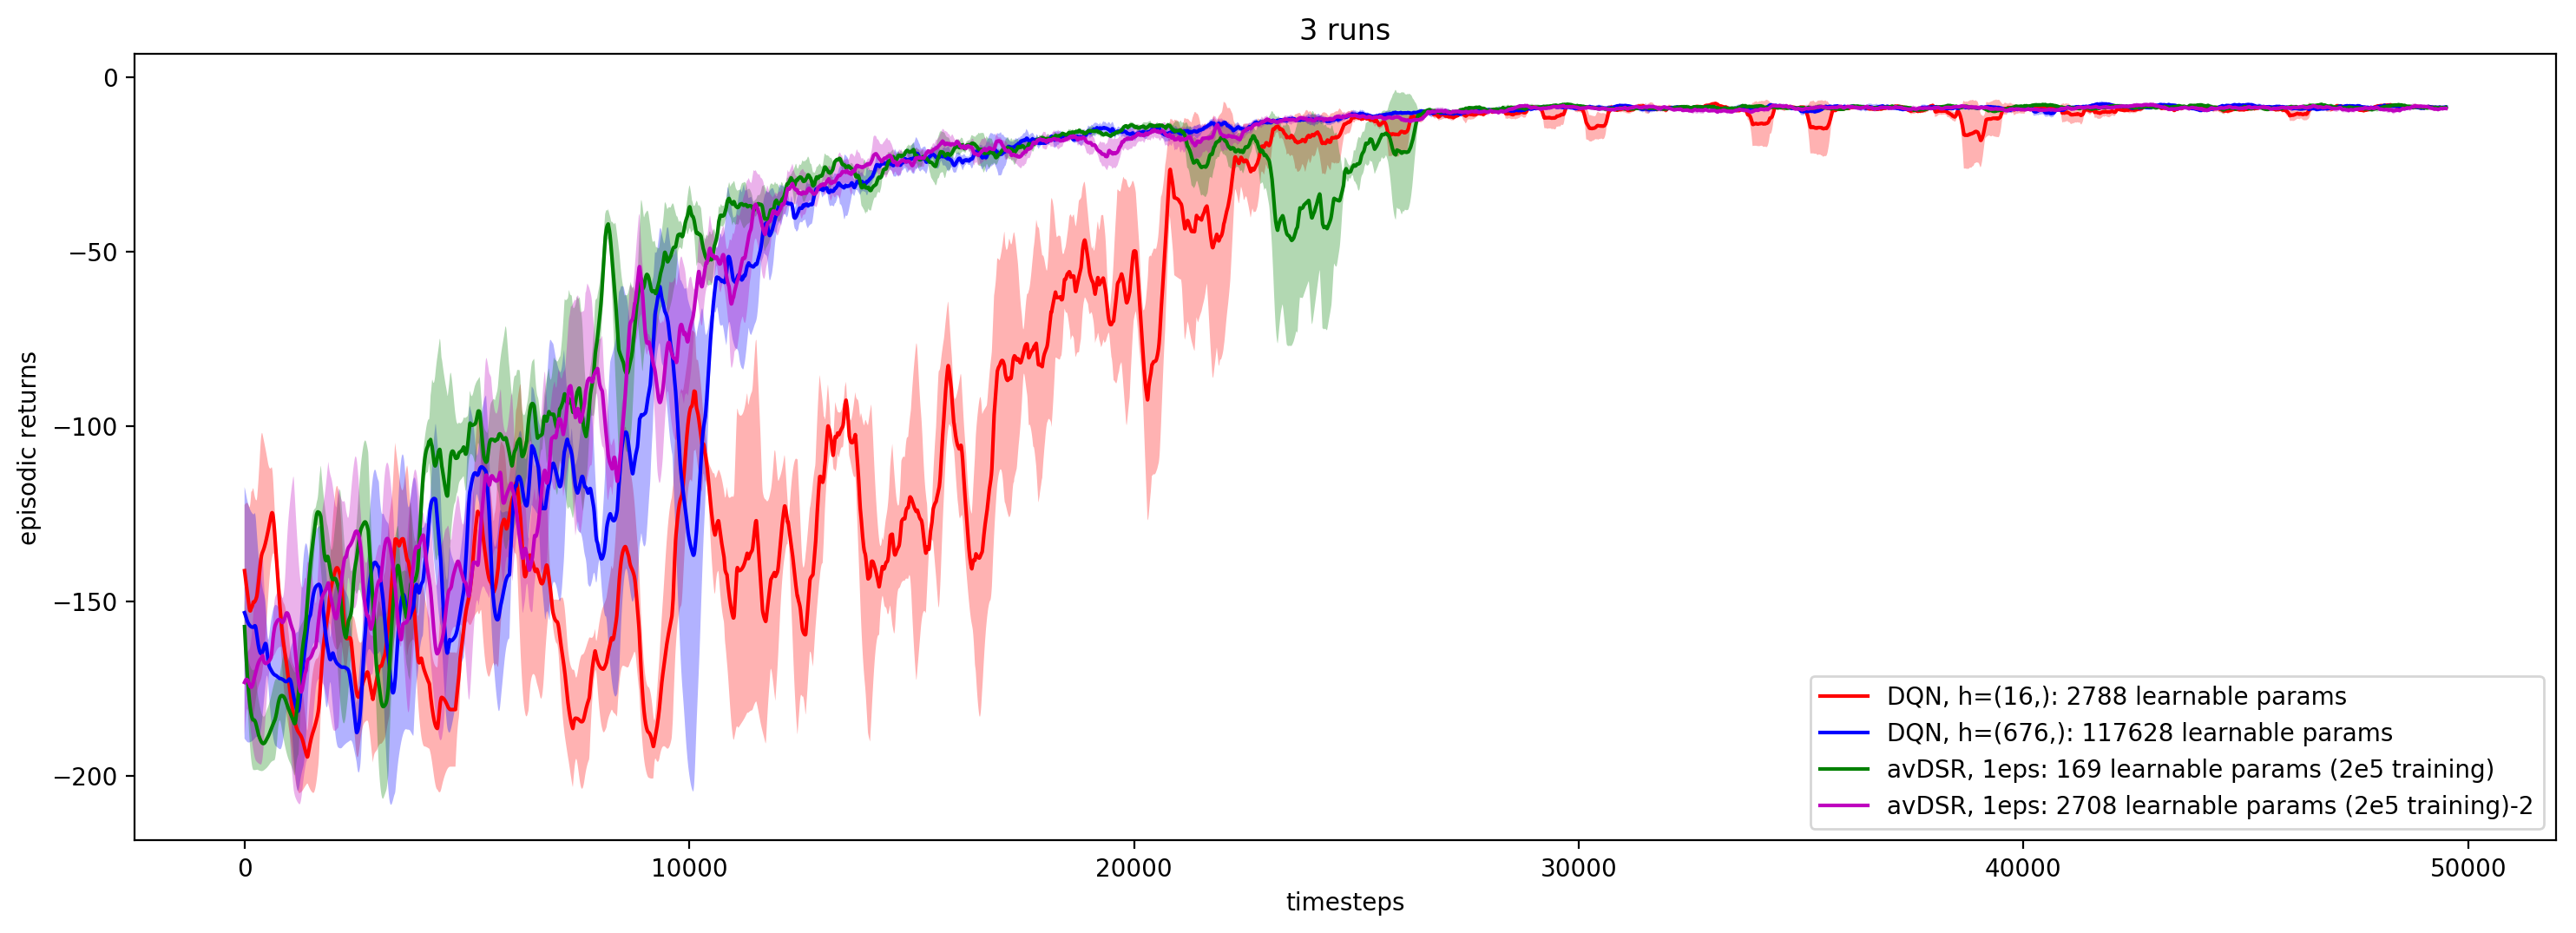

In [28]:
rewards_dict = {
#     'avDSR, 1eps: 2708 learnable params (2e5 training)': r_dsr_abs_rand[1:],
                'DQN, h=(16,): 2788 learnable params': r_dqn_base[1:],
               'DQN, h=(676,): 117628 learnable params': r_dqn_base2[1:],
               'avDSR, 1eps: 169 learnable params (2e5 training)': r_c0[1:],
               'avDSR, 1eps: 2708 learnable params (2e5 training)-2': r_c1[1:]
               }
# rewards_dict = {'avDSR, 1eps: 169 learnable params':r_dsr_rand,
#                 'avDSR, 1eps: 2708 learnable params':r_dsr_abs_rand[1:],
#                 'DQN, h=(676,): 117628 learnable params': r_dqn_base,
#                'DQN, h=(16,): 2788 learnable params': r_dqn_base2[1:]}
# plot_rewards(rewards_dict, plot_seperate=True)
plot_rewards(rewards_dict, plot_seperate=False, title='3 runs')

In [24]:
import pickle
    
# with open('storage/rewards.pickle', 'wb') as f:
#     pickle.dump(rewards_dict, f, pickle.HIGHEST_PROTOCOL)
    
with open('storage/rewards.pickle', 'rb') as f:
    rewards = pickle.load(f)

r_dsr_rand = rewards['avDSR, 1eps: 169 learnable params']
r_dqn_base = rewards['DQN, h=(676,): 117628 learnable params']

### ROUGH BELOW

In [10]:
"""
Adopted from https://github.com/alversafa/option-critic-arch/blob/master/fourrooms.py.

Modified to return one hot encoded states and gym compatible.

"""

import numpy as np
from gym.utils import seeding
from gym import spaces
import gym

class FourRoomsMatrix(gym.Env):

    def __init__(self, goal=62, p=0, config=2):
        """
        config -> configouration of the state space
            0 - returns tabular index of the state
            1 - returns one hot encoded vector of the state
            2 - returns matrix form of the state
        """
        layout = """\
wwwwwwwwwwwww
w     w     w
w     w     w
w           w
w     w     w
w     w     w
ww wwww     w
w     www www
w     w     w
w     w     w
w           w
w     w     w
wwwwwwwwwwwww
"""
        self.p = p # Stocasticity the environment
        self.config = config
        self.occupancy = np.array([list(map(lambda c: 1 if c=='w' else 0, line)) for line in layout.splitlines()])
        
        # Four possible actions
        # 0: UP
        # 1: DOWN
        # 2: LEFT
        # 3: RIGHT
        self.a_space = np.array([0, 1, 2, 3])
        self.obs_space = np.zeros(np.sum(self.occupancy == 0))
        self.observation_space = spaces.Box(low=np.zeros(np.sum(self.occupancy == 0)), high=np.ones(np.sum(self.occupancy == 0)), dtype=np.uint8)
        self.action_space = spaces.Discrete(4)
        self.directions = [np.array((-1,0)), np.array((1,0)), np.array((0,-1)), np.array((0,1))]

        # Random number generator
        self.rng = np.random.RandomState(1234)

        self.tostate = {}
        statenum = 0
        for i in range(13):
            for j in range(13):
                if self.occupancy[i,j] == 0:
                    self.tostate[(i,j)] = statenum
                    statenum += 1
        self.tocell = {v:k for k, v in self.tostate.items()}


        self.goal = goal # East doorway
        self.init_states = list(range(self.obs_space.shape[0]))
        self.init_states.remove(self.goal)
        self.updates = 0
        self.horizon = 200


    def render(self, show_goal=True):
        current_grid = np.array(self.occupancy)
        current_grid[self.current_cell[0], self.current_cell[1]] = -1
        if show_goal:
            goal_cell = self.tocell[self.goal]
            current_grid[goal_cell[0], goal_cell[1]] = -2
        return current_grid

    def seed(self, seed=None):
        """
        Setting the seed of the agent for replication
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        state = self.rng.choice(self.init_states)
        # state = 0 # fix starting state
        self.current_cell = self.tocell[state]
        if(self.config == 0):
            return state
        elif(self.config == 1):
            temp = np.zeros(len(self.obs_space))
            temp[state] = 1
            self.updates = 0
            return temp
        elif(self.config == 2):
            return env.render()
        else:
            raise
            

    def check_available_cells(self, cell):
        available_cells = []

        for action in range(len(self.a_space)):
            next_cell = tuple(cell + self.directions[action])

            if not self.occupancy[next_cell]:
                available_cells.append(next_cell)

        return available_cells
        

    def step(self, action):
        '''
        Takes a step in the environment with 1-self.p probability. And takes a step in the
        other directions with probability self.p with all of them being equally likely.
        '''
        self.updates += 1

        next_cell = tuple(self.current_cell + self.directions[action])

        if not self.occupancy[next_cell]:

            if self.rng.uniform() < self.p:
                available_cells = self.check_available_cells(self.current_cell)
                self.current_cell = available_cells[self.rng.randint(len(available_cells))]

            else:
                self.current_cell = next_cell

        state = self.tostate[self.current_cell]

        # When goal is reached, it is done
        done = state == self.goal

        if(done):
            reward = 0
        else:
            reward = -1

        if(self.updates>=self.horizon):
            reward = -1
            done = True

        if(self.config == 0):
            return state, reward, done, {}
        elif(self.config == 1):
            temp = np.zeros(len(self.obs_space))
            temp[state] = 1
            return temp, reward, done, {}
        elif(self.config == 2):
            return env.render, reward, done, {}

        